In [81]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
dirs = os.listdir('./runs/')
df_model = pd.DataFrame()
df_real = pd.DataFrame()

for dir in dirs:
    files = os.listdir(f'./runs/{dir}')
    files_path = [f'./runs/{dir}/{f}' for f in files if f.endswith('.json')]
    
    df_model_aux = pd.read_json(files_path[0])
    df_real_aux = pd.read_json(files_path[1])

    df_model_aux['algorithm'] = dir
    df_real_aux['algorithm'] = dir

    df_model_aux = df_model_aux[df_model_aux['data'].notna()][['data', 'algorithm']]
    df_real_aux = df_real_aux[df_real_aux['data'].notna()][['data', 'algorithm']]

    df_model = pd.concat([df_model, df_model_aux])
    df_real = pd.concat([df_real, df_real_aux])

In [66]:
test = [data for data in df_model['data'] if data['start_time'] != 0]
test

[{'start_time': 1714167887.4280956, 'stop_time': 1714167887.4958193},
 {'start_time': 1714167887.4961445, 'stop_time': 1714167887.5643606},
 {'start_time': 1714167887.5646536, 'stop_time': 1714167887.6324298},
 {'start_time': 1714167887.6326969, 'stop_time': 1714167887.7001405},
 {'start_time': 1714167887.7004278, 'stop_time': 1714167887.7688189},
 {'start_time': 1714167887.7691004, 'stop_time': 1714167887.8383245},
 {'start_time': 1714167887.8386006, 'stop_time': 1714167887.906347},
 {'start_time': 1714167887.9066272, 'stop_time': 1714167887.973814},
 {'start_time': 1714167887.9740882, 'stop_time': 1714167888.0414388},
 {'start_time': 1714167888.0417154, 'stop_time': 1714167888.108529},
 {'start_time': 1714167888.1088674, 'stop_time': 1714167888.2050343},
 {'start_time': 1714167888.2053444, 'stop_time': 1714167888.3043158},
 {'start_time': 1714167888.3046155, 'stop_time': 1714167888.3959687},
 {'start_time': 1714167888.396328, 'stop_time': 1714167888.4889834},
 {'start_time': 17141678

In [78]:
df_model['data'] = df_model['data'].apply(lambda x: x if x['start_time'] != 0 else None)
df_model = df_model.dropna()

In [79]:
df_model['exec_time'] = df_model['data'].apply(lambda x: x['stop_time'] - x['start_time'])
df_real['exec_time'] = df_real['data'].apply(lambda x: x['stop_time'] - x['start_time'])

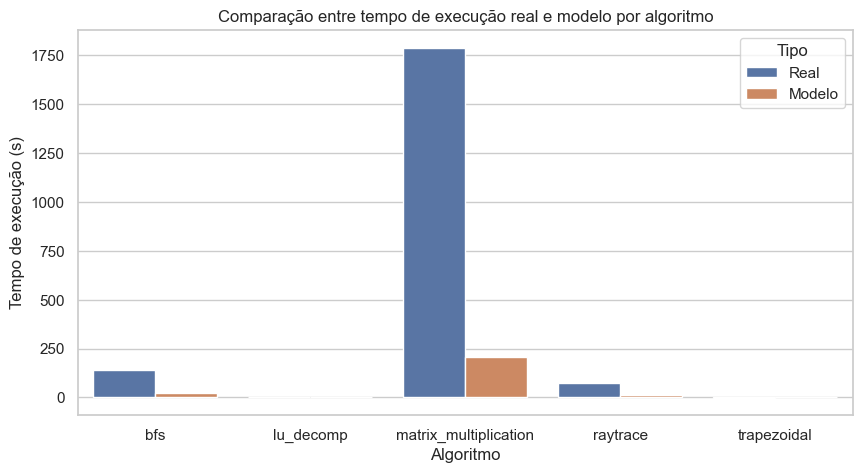

In [121]:
algorithms = df_real['algorithm'].unique()
data = []
for algo in algorithms:
    data.append({'Algoritmo': algo, 'Tipo': 'Real', 'Tempo': df_real[df_real['algorithm'] == algo]['exec_time'].sum()})
    data.append({'Algoritmo': algo, 'Tipo': 'Modelo', 'Tempo': df_model[df_model['algorithm'] == algo]['exec_time'].sum()})

df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Algoritmo', y='Tempo', hue='Tipo')
plt.xlabel('Algoritmo')
plt.ylabel('Tempo de execução (s)')
plt.title('Comparação entre tempo de execução real e modelo por algoritmo')
plt.legend(title='Tipo')
plt.show()